In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np

import sys
sys.path.append('../qubo')

## Collect total delay data ##

In [2]:
pmin = 0
pmax = 45
numDelaysList = range(1,100)
maxDelaysList = [12, 24, 36, 48, 60]
totaldelays = {}
totaldelays_cont = {}
numFlights = {}
numConflicts = {}
for partition in range(pmin, pmax + 1):
    # get number of flights and conflicts
    instancefile = '../data/instances/atm_instance_partition%04i_delayStep%03i_maxDelay%03i.h5' % (partition, 9, 18)
    f = h5py.File(instancefile, 'r')
    numFlights[partition] = f['atm-instance'].attrs['Number of flights']
    numConflicts[partition] = f['atm-instance'].attrs['Number of conflicts']
    f.close()
    resultfile = '../data/results/atm_instance_partition%04i.results.h5' % partition

    f = h5py.File(resultfile, 'r')
    tdc = {}
    for maxDelay in maxDelaysList:
        td = []
        nd = []
        for numDelays in numDelaysList:
            groupname = "solution_constraint_programming_numDelays%03i_maxDelay%03i" % (numDelays, maxDelay)
            if groupname in f:
                g = f[groupname]
                if 'total delay' in g.attrs.keys():
                    td.append(g.attrs['total delay'])
                    nd.append(numDelays)
        if not all(np.array(td) == 0):
            if not partition in totaldelays:
                totaldelays[partition] = {}
            totaldelays[partition][maxDelay] = (nd, td)
        # get results for continuous variables
        groupname = "solution_constraint_programming_numDelays%03i_maxDelay%03i" % (0, maxDelay)
        if groupname in f:
            g = f[groupname]
            if 'total delay' in g.attrs.keys():
                tdc[maxDelay] = (g.attrs['total delay'])
    if not all(np.array(tdc.values()) == 0):
        totaldelays_cont[partition] = tdc
    f.close()

## Collect data from continuous model ##

In [3]:
maxDelaysListCont = range(1, 120 + 1)
totaldelays_cont = {}

for partition in range(pmin, pmax + 1):
    resultfile = '../data/results/atm_instance_partition%04i.results.h5' % partition

    f = h5py.File(resultfile, 'r')
    td = []
    md = []
    for maxDelay in maxDelaysListCont:
        groupname = "solution_constraint_programming_numDelays%03i_maxDelay%03i" % (0, maxDelay)
        if groupname in f:
            g = f[groupname]
            if 'total delay' in g.attrs.keys():
                td.append(g.attrs['total delay'])
                md.append(maxDelay)
    if not all(np.array(td) == 0):
        totaldelays_cont[partition] = (md, td)
    f.close()   

In [4]:
if not set(totaldelays.keys()) == set(totaldelays_cont.keys()):
    print """WARNING: There are partitions which have trivial solutions 
             in the discrete model and non-trivial in the continuous model or vice-versa"""

In [5]:
# get the minimum total delay in the solution to the continuous model
tdc_min = {}
# and get corresponding value of d_max
dmaxmin = {}
for partition in totaldelays_cont.keys():
    tdc = totaldelays_cont[partition][1]
    dmax = totaldelays_cont[partition][0]
    tdcmin = min(tdc)
    tdc_min[partition] = tdcmin
    dmaxmin[partition] = dmax[tdc.index(tdcmin)]

## Plot total delay of solution versus number of delay steps ##

In [7]:
%matplotlib inline

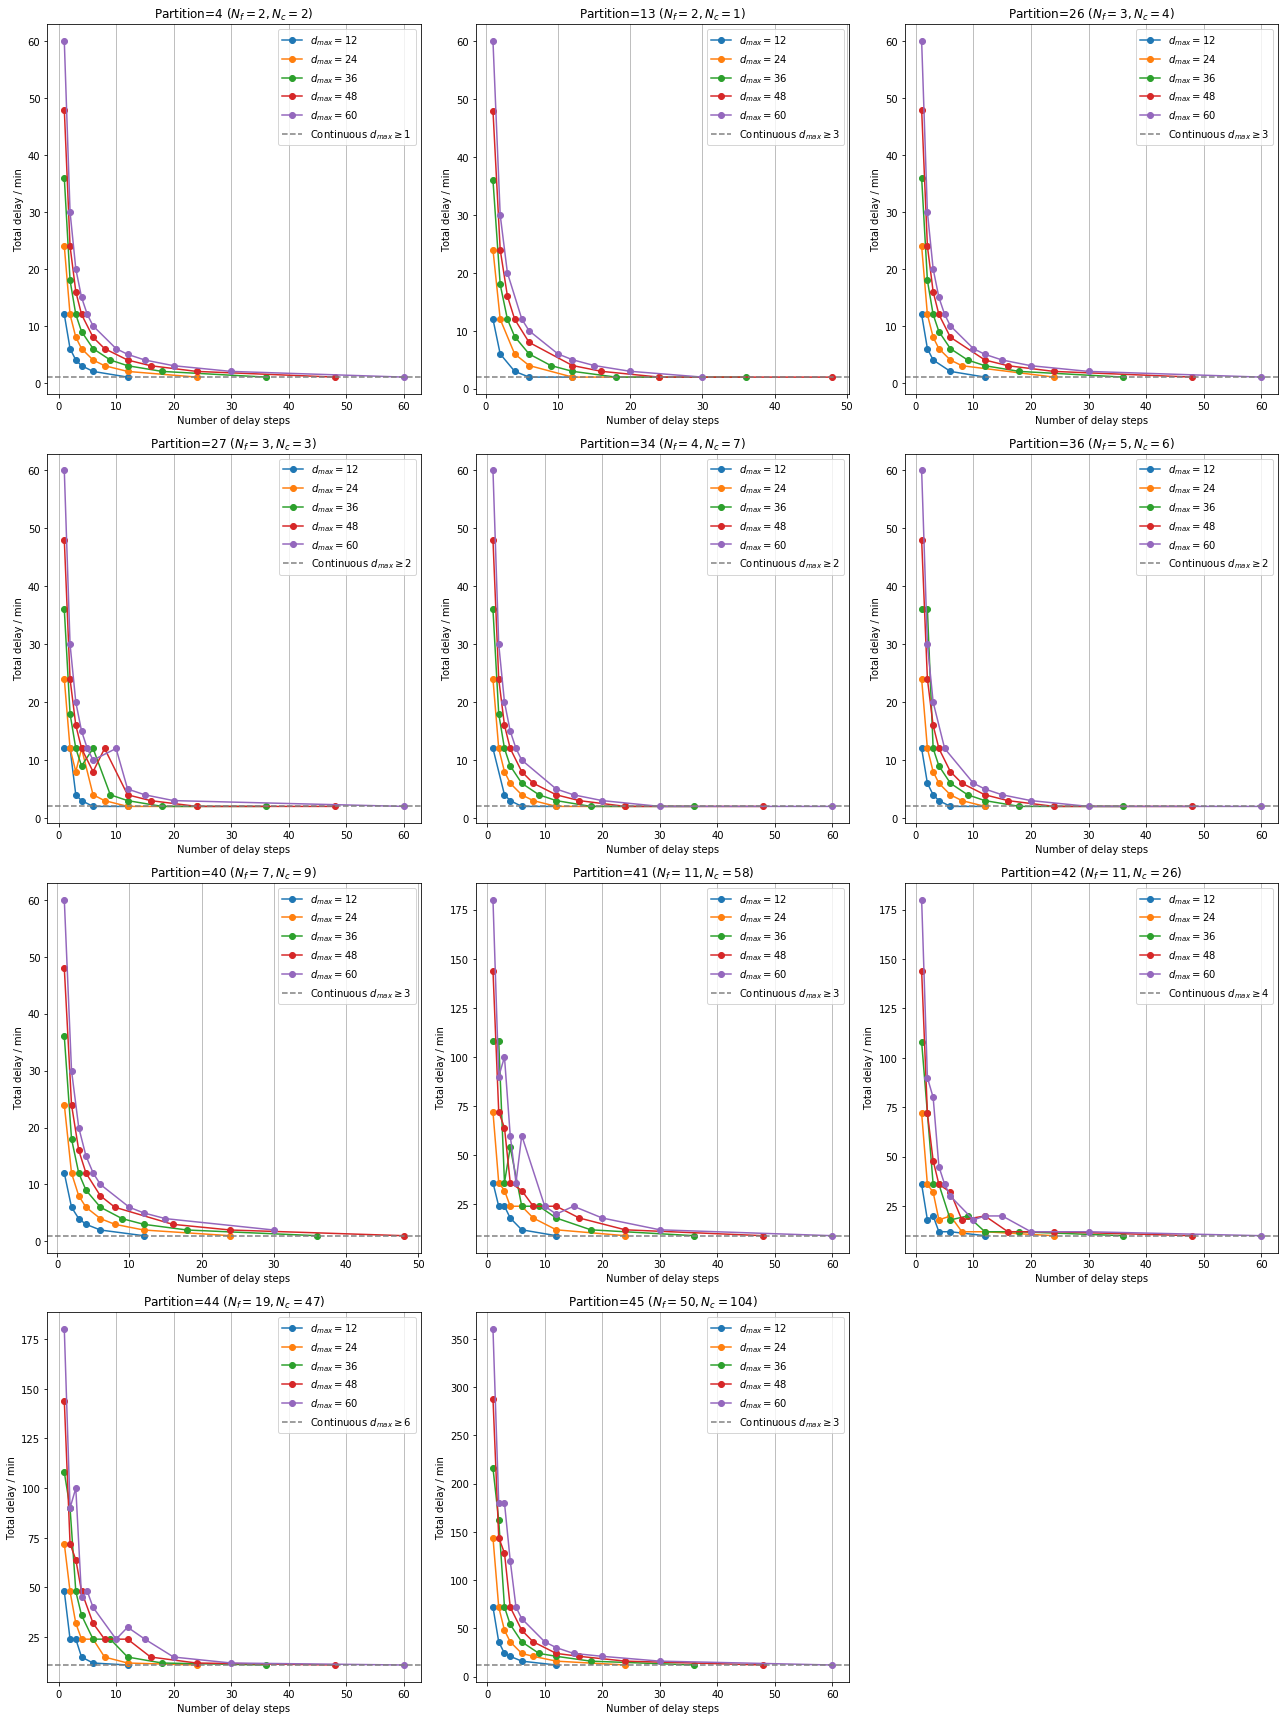

In [7]:
ncol = 3
Np = len(totaldelays.keys())
nrow = Np / ncol + (Np % ncol != 0)
fig = plt.figure(figsize=(6 * ncol, 6 * nrow))
n = 0
for partition in sorted(totaldelays.keys()):
    ax = fig.add_subplot(nrow, ncol, n + 1)
    td = totaldelays[partition]
    for maxDelay in sorted(td.keys()):
        ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
    ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
    ax.legend(loc='upper right')
    ax.grid(axis='x')
    ax.set_xlabel('Number of delay steps')
    ax.set_ylabel('Total delay / min')
    ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]))

    n = n + 1
plt.tight_layout()


## Save plots to PDF file ##

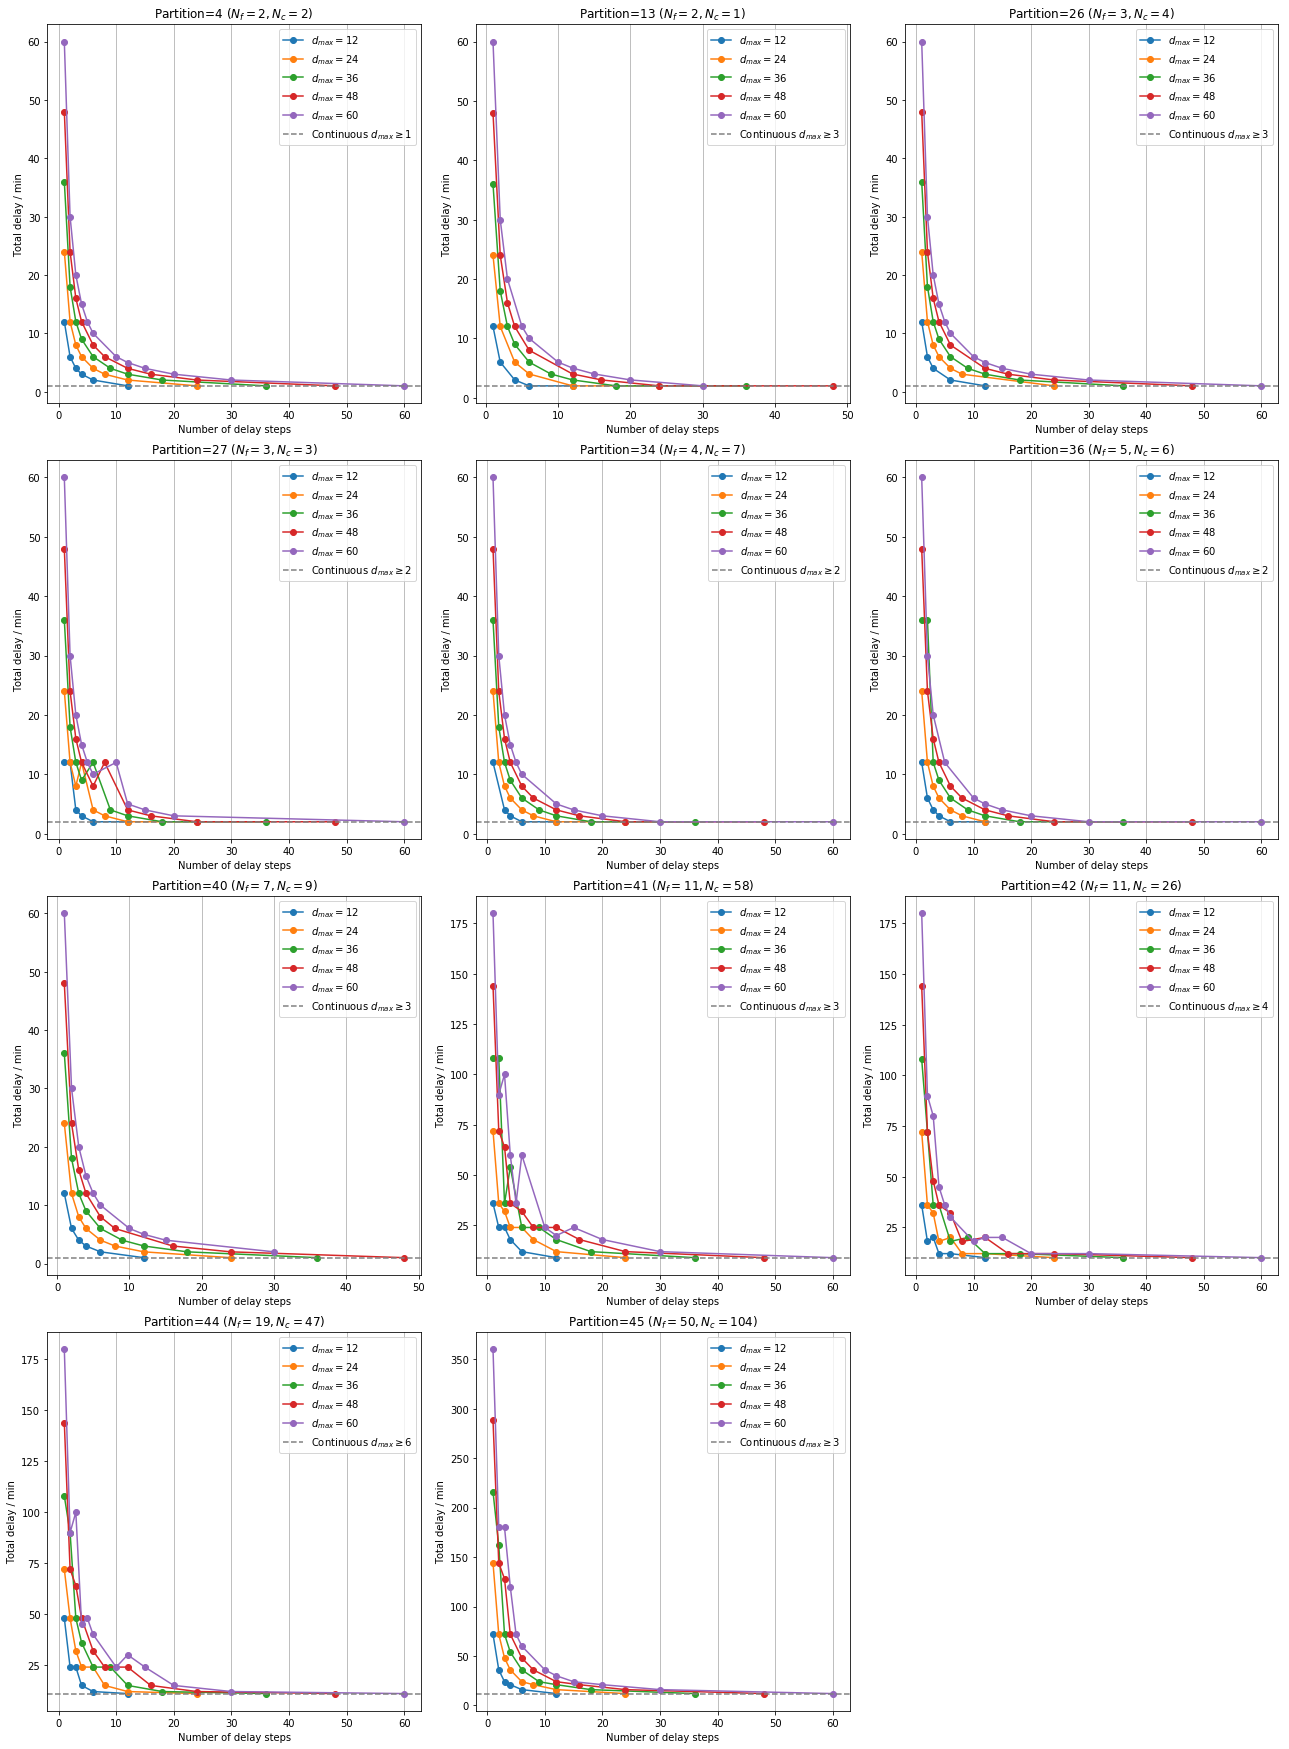

In [8]:
nperpage = 5

ncol = 3
Np = len(totaldelays.keys())
nrow = Np / ncol + (Np % ncol != 0)
pdf = matplotlib.backends.backend_pdf.PdfPages('totalDelayVsNumDelay.pdf');
n = 0
for partition in sorted(totaldelays.keys()):
    if n % (ncol * nperpage) == 0:
        fig = plt.figure(figsize=(6 * ncol, 6 * nperpage));

    ax = fig.add_subplot(nperpage, ncol, n % (ncol * nperpage) + 1)
    td = totaldelays[partition]
    for maxDelay in sorted(td.keys()):
        ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
    ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])

    ax.legend(loc='upper right')
    ax.grid(axis='x')
    ax.set_xlabel('Number of delay steps')
    ax.set_ylabel('Total delay / min')
    ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]))
    
    if n % (ncol * nperpage) == ncol * nperpage - 1:
        pdf.savefig(figure=fig);
    n = n + 1
pdf.savefig(figure=fig);
pdf.close();
plt.tight_layout()

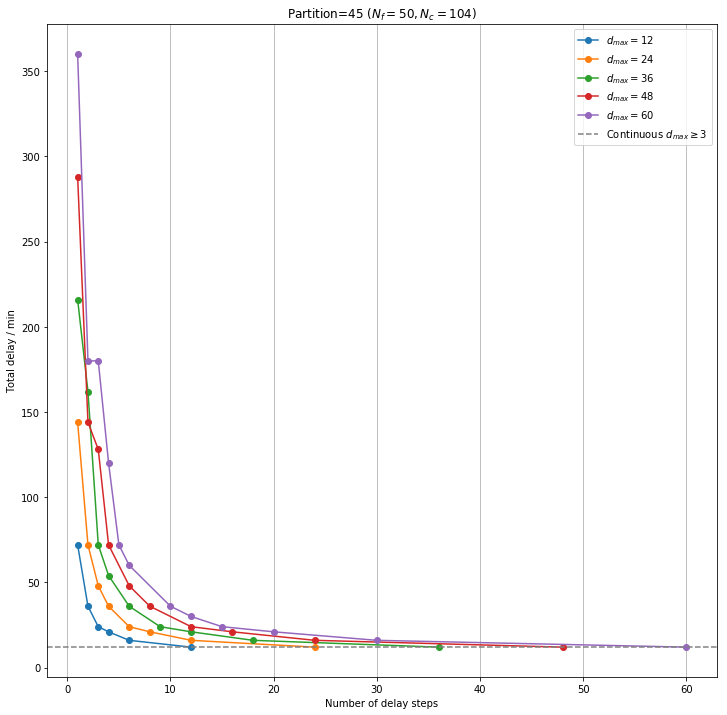

In [9]:

fig = plt.figure(figsize=(12 , 12))
partition = 45
ax = fig.add_subplot(1, 1, 1)


td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])

ax.set_title("Partition %i" % partition)
#ax.set_xticks(range(0, 200, maxDelay))
ax.legend(loc='upper right')
ax.grid(axis='x')
ax.set_xlabel('Number of delay steps')
ax.set_ylabel('Total delay / min')
ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]));
plt.show()

## Total delay vs 1 / delay step size ##

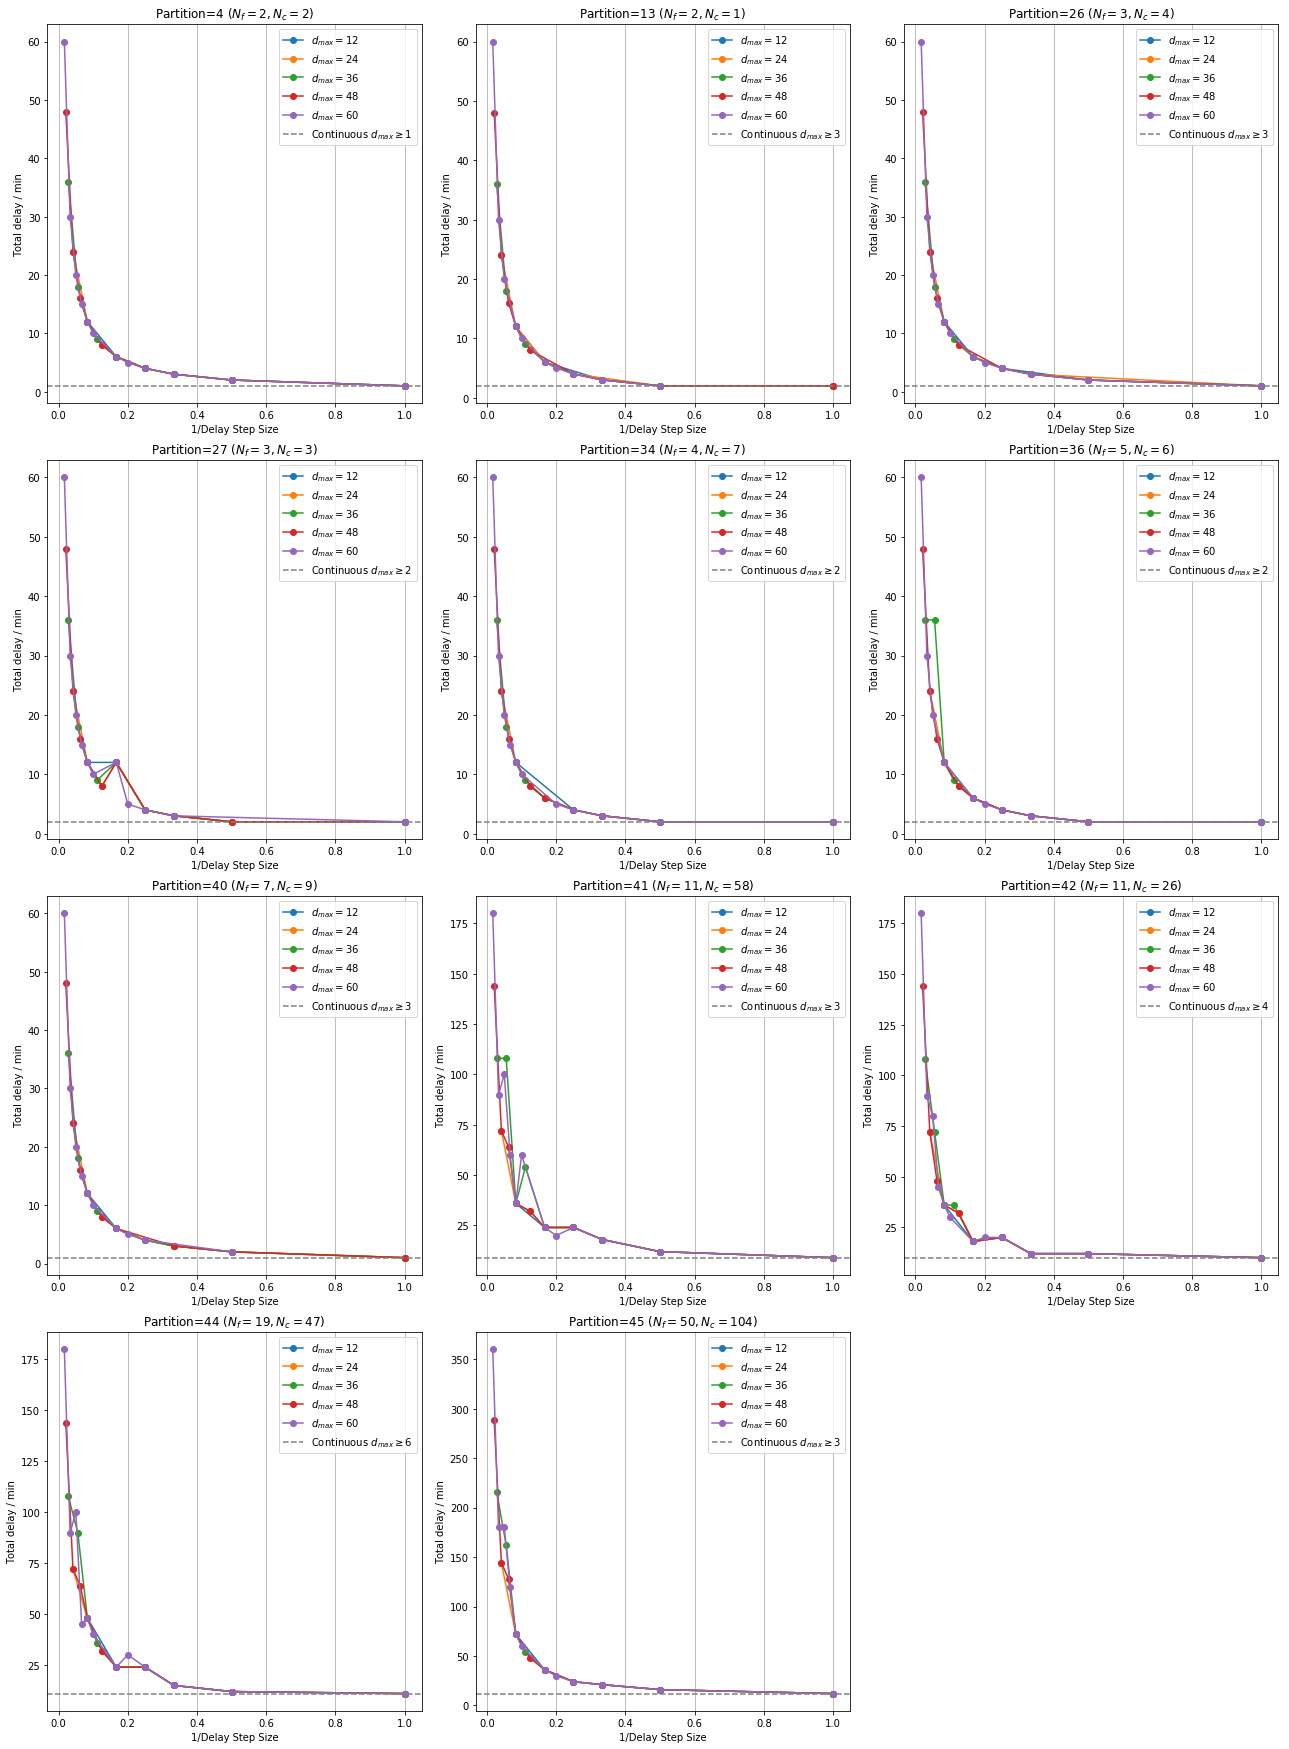

In [10]:
nperpage = 5

ncol = 3
Np = len(totaldelays.keys())
nrow = Np / ncol + (Np % ncol != 0)
pdf = matplotlib.backends.backend_pdf.PdfPages('totalDelayVsOneOverDelayStepSize.pdf');
n = 0
for partition in sorted(totaldelays.keys()):
    if n % (ncol * nperpage) == 0:
        fig = plt.figure(figsize=(6 * ncol, 6 * nperpage));

    ax = fig.add_subplot(nperpage, ncol, n % (ncol * nperpage) + 1)
    td = totaldelays[partition]
    for maxDelay in sorted(td.keys()):
        ax.plot(np.array(td[maxDelay][0], dtype=float)/maxDelay, td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
    ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
    ax.legend(loc='upper right')
    ax.grid(axis='x')
    ax.set_xlabel('1/Delay Step Size')
    ax.set_ylabel('Total delay / min')
    ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]))
    
    if n % (ncol * nperpage) == ncol * nperpage - 1:
        pdf.savefig(figure=fig);
    n = n + 1
pdf.savefig(figure=fig);
pdf.close();
plt.tight_layout()

## Total delay vs delay step size ##

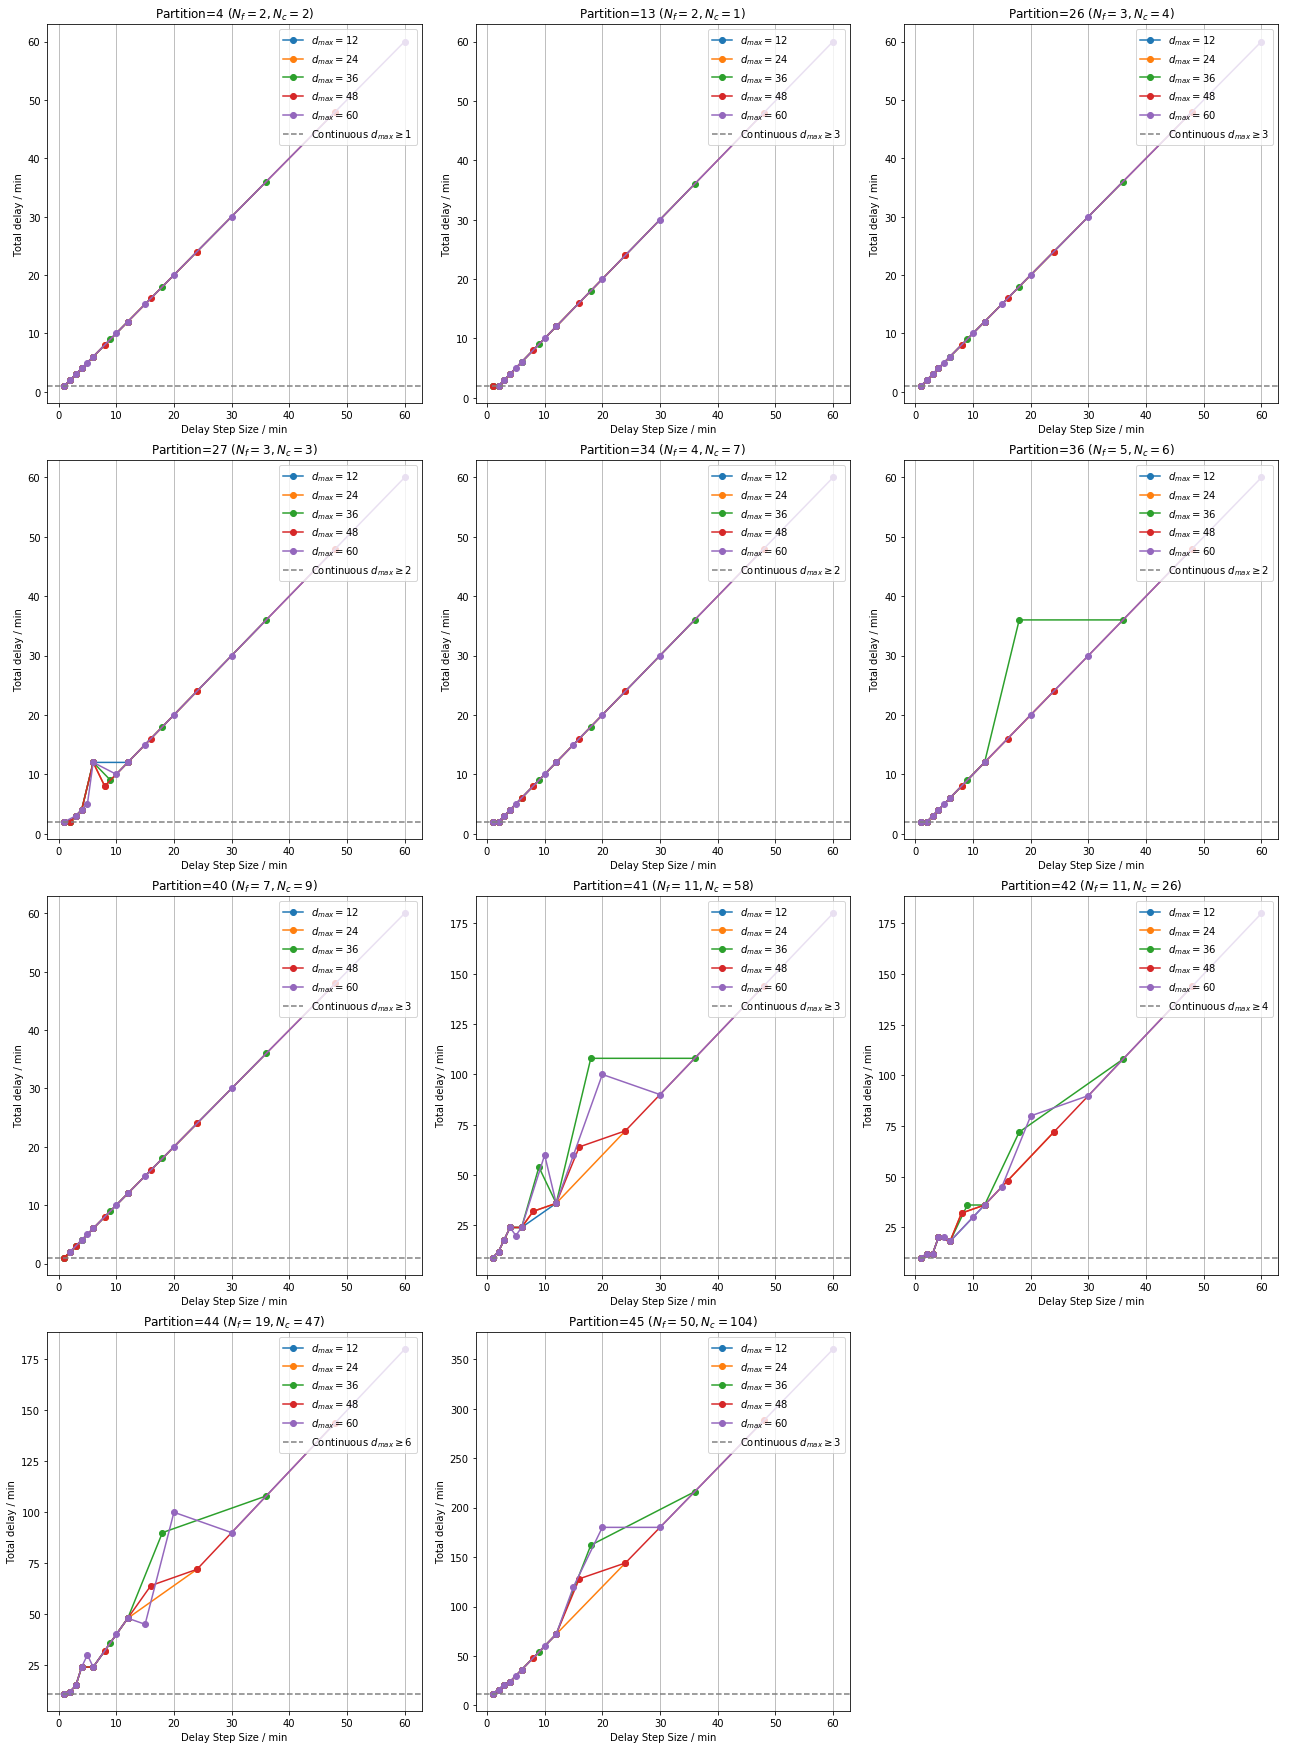

In [11]:
nperpage = 5

ncol = 3
Np = len(totaldelays.keys())
nrow = Np / ncol + (Np % ncol != 0)
pdf = matplotlib.backends.backend_pdf.PdfPages('totalDelayVsDelayStepSize.pdf');
n = 0
for partition in sorted(totaldelays.keys()):
    if n % (ncol * nperpage) == 0:
        fig = plt.figure(figsize=(6 * ncol, 6 * nperpage));

    ax = fig.add_subplot(nperpage, ncol, n % (ncol * nperpage) + 1)
    td = totaldelays[partition]
    for maxDelay in sorted(td.keys()):
        ax.plot(maxDelay/np.array(td[maxDelay][0], dtype=float), td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
    ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])

    ax.legend(loc='upper right')
    ax.grid(axis='x')
    ax.set_xlabel('Delay Step Size / min')
    ax.set_ylabel('Total delay / min')
    ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]))
    
    if n % (ncol * nperpage) == ncol * nperpage - 1:
        pdf.savefig(figure=fig);
    n = n + 1
pdf.savefig(figure=fig);
pdf.close();
plt.tight_layout()

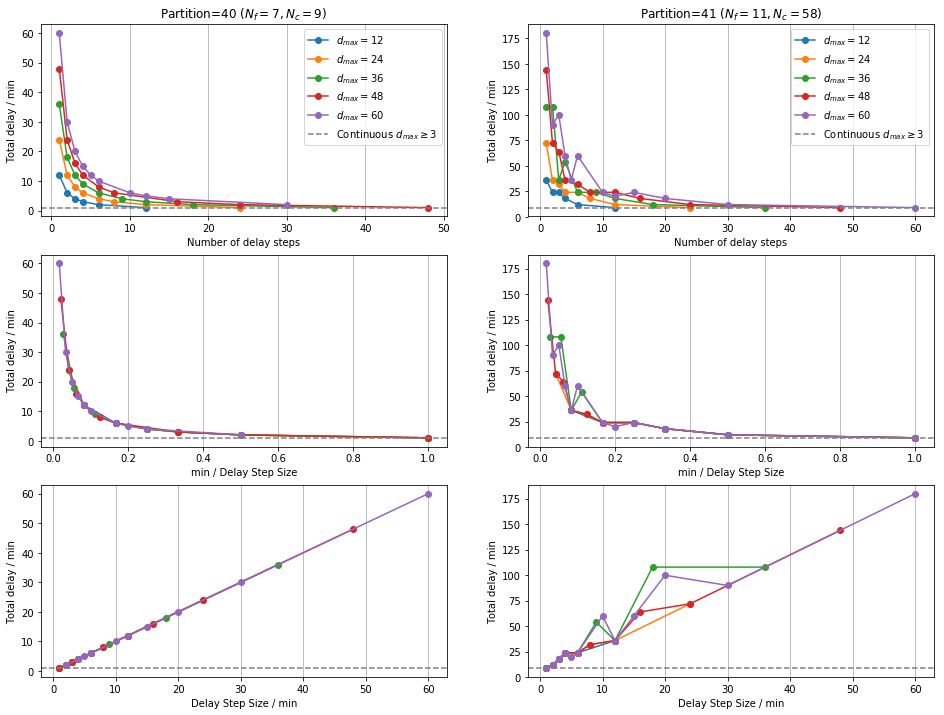

In [12]:
pdf = matplotlib.backends.backend_pdf.PdfPages('totalDelayVsDelayStep_examples.pdf');
fig = plt.figure(figsize=(16, 12));

ax = fig.add_subplot(3, 2, 1)
partition = 40
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])

ax.set_title("Partition %i" % partition)
#ax.set_xticks(range(0, 200, maxDelay))
ax.legend(loc='upper right')
ax.grid(axis='x')
ax.set_xlabel('Number of delay steps')
ax.set_ylabel('Total delay / min')
ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]));

ax = fig.add_subplot(3, 2, 2)
partition = 41
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.set_title("Partition %i" % partition)
#ax.set_xticks(range(0, 200, maxDelay))
ax.legend(loc='upper right')
ax.grid(axis='x')
ax.set_xlabel('Number of delay steps')
ax.set_ylabel('Total delay / min')
ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]));

ax = fig.add_subplot(3, 2, 3)
partition = 40
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(np.array(td[maxDelay][0], dtype=float)/maxDelay, td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('min / Delay Step Size')
ax.set_ylabel('Total delay / min')

ax = fig.add_subplot(3, 2, 4)
partition = 41
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(np.array(td[maxDelay][0], dtype=float)/maxDelay, td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('min / Delay Step Size')
ax.set_ylabel('Total delay / min')

ax = fig.add_subplot(3, 2, 5)
partition = 40
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(maxDelay/np.array(td[maxDelay][0], dtype=float), td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('Delay Step Size / min')
ax.set_ylabel('Total delay / min')

ax = fig.add_subplot(3, 2, 6)
partition = 41
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(maxDelay/np.array(td[maxDelay][0], dtype=float), td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('Delay Step Size / min')
ax.set_ylabel('Total delay / min')

pdf.savefig(figure=fig);
pdf.close();
#plt.tight_layout()

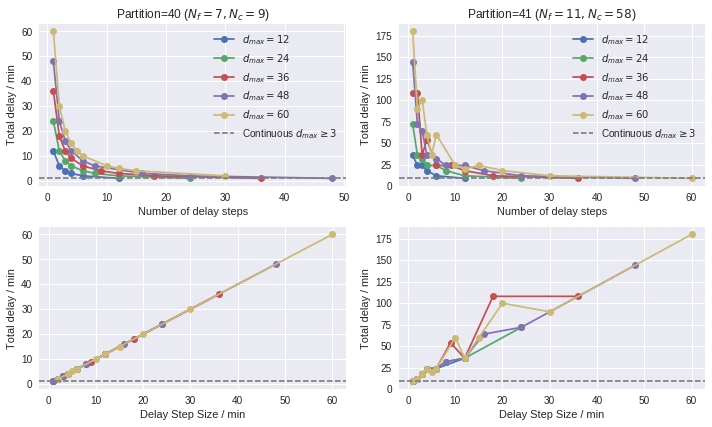

In [8]:
import seaborn
pdf = matplotlib.backends.backend_pdf.PdfPages('totalDelayVsDelayStep_examples_2.pdf');
fig = plt.figure(figsize=(10, 6));

ax = fig.add_subplot(2, 2, 1)
partition = 40
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])

ax.set_title("Partition %i" % partition)
#ax.set_xticks(range(0, 200, maxDelay))
ax.legend(loc='upper right')
ax.grid(axis='x')
ax.set_xlabel('Number of delay steps')
ax.set_ylabel('Total delay / min')
ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]));
ax.grid(True)

ax = fig.add_subplot(2, 2, 2)
partition = 41
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(td[maxDelay][0], td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.set_title("Partition %i" % partition)
#ax.set_xticks(range(0, 200, maxDelay))
ax.legend(loc='upper right')
ax.grid(axis='x')
ax.set_xlabel('Number of delay steps')
ax.set_ylabel('Total delay / min')
ax.set_title('Partition=%i ($N_f=%i, N_c=%i$)' % (partition, numFlights[partition], numConflicts[partition]));
ax.grid(True)

ax = fig.add_subplot(2, 2, 3)
partition = 40
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(maxDelay/np.array(td[maxDelay][0], dtype=float), td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('Delay Step Size / min')
ax.set_ylabel('Total delay / min')
ax.grid(True)

ax = fig.add_subplot(2, 2, 4)
partition = 41
td = totaldelays[partition]
for maxDelay in sorted(td.keys()):
    ax.plot(maxDelay/np.array(td[maxDelay][0], dtype=float), td[maxDelay][1], 'o-', label='$d_{max} = %i$' % maxDelay)
ax.axhline(y=tdc_min[partition], linestyle='--', color='gray', label='Continuous $d_{max} \geq %i$' % dmaxmin[partition])
ax.grid(axis='x')
ax.set_xlabel('Delay Step Size / min')
ax.set_ylabel('Total delay / min')
ax.grid(True)

pdf.savefig(figure=fig);
pdf.close();
plt.tight_layout()